# Gaussian process regression

Adapted from [NumPyro's GP example](https://num.pyro.ai/en/stable/examples/gp.html).

In [121]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import jax.random as random

from functools import partial
from gaul import quap

import matplotlib.pyplot as plt
import seaborn as sns
import pears

plt.rcParams['figure.figsize'] = (11, 7)

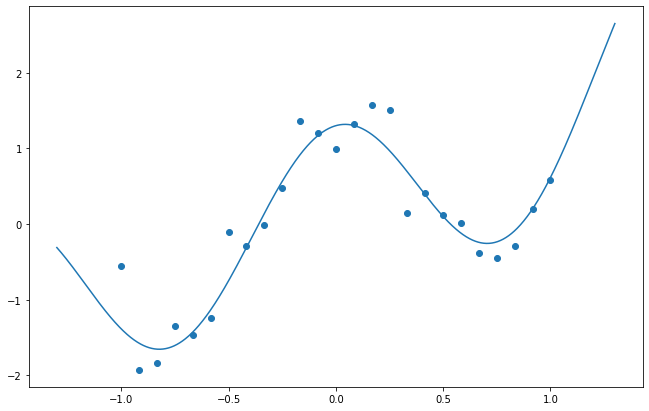

In [236]:
rng = random.PRNGKey(0)

n_train = 25
n_test = 400
sigma_obs = 0.3

fn = lambda x: 20. * jnp.sin(x / 40.) + \
    0.1 * jnp.power(x, 3.0) + \
    0.1 * jnp.power(1. + x, 3.0) + \
    1.2 * jnp.cos(4.0 * x)
    
x = jnp.linspace(-1, 1, n_train)
y = fn(x)
y += sigma_obs * random.normal(rng, shape=(n_train,))
y -= jnp.mean(y)
y /= jnp.std(y)

x_test = jnp.linspace(-1.3, 1.3, n_test)

x_true = jnp.linspace(-1.3, 1.3, 1000)
y_true = fn(x_true)

plt.scatter(x, y)
plt.plot(x_true, y_true)

In [210]:
@partial(jax.jit, static_argnames=['include_noise'])
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k

In [211]:
@jax.jit
def ln_posterior(params, data):
    target = 0
    
    target += stats.norm.logpdf(params['log_kernel_var'], 0., 10.)
    target += stats.norm.logpdf(params['log_kernel_noise'], 0., 10.)
    target += stats.norm.logpdf(params['log_kernel_length'], 0., 10.)

    k = kernel(
        data['X'], data['X'], 
        jnp.exp(params['log_kernel_var']), 
        jnp.exp(params['log_kernel_length']), 
        jnp.exp(params['log_kernel_noise'])
    )

    target += stats.multivariate_normal.logpdf(
        data['Y'], 
        jnp.zeros(data['X'].shape[0]), 
        k
    ).sum()
    
    return target.sum()

In [212]:
params = dict(
    log_kernel_var=jnp.zeros(1),
    log_kernel_noise=jnp.zeros(1),
    log_kernel_length=jnp.zeros(1),
)

data = dict(
    X=x,
    Y=y,
)

In [213]:
samples = quap.sample(
    ln_posterior,
    params,
    n_steps=5000,
    n_samples=2000,
    data=data
)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [214]:
samples = jax.tree_util.tree_map(lambda x: x.reshape(-1), samples)

In [215]:
@jax.jit
def predict(rng_key, X, Y, X_test, var, length, noise):
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - k_pX @ (K_xx_inv @ k_pX.T)
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1]
    )
    mean = k_pX @ (K_xx_inv @ Y)
    return mean, mean + sigma_noise

In [216]:
means, predictions = jax.vmap(
    predict, 
    in_axes=(0, None, None, None, 0, 0, 0)
)(
    random.split(rng, samples["log_kernel_var"].shape[0]),
    x, y, x_test,
    jnp.exp(samples["log_kernel_var"]),
    jnp.exp(samples["log_kernel_length"]),
    jnp.exp(samples["log_kernel_noise"]),
)

In [217]:
mean_prediction = jnp.mean(means, axis=0)
percentiles = jnp.percentile(predictions, jnp.array([5., 95.]), axis=0)

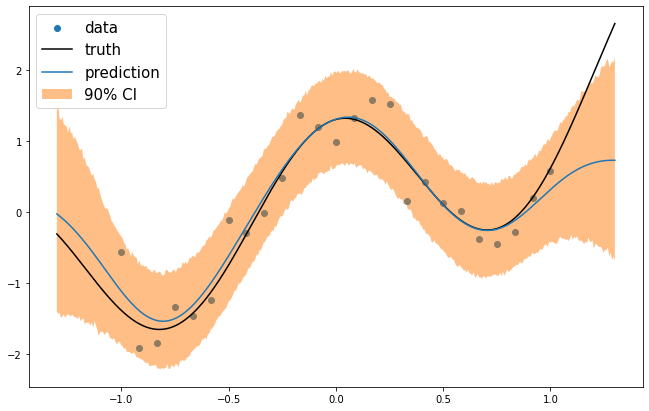

In [237]:
plt.scatter(x, y, label='data')
plt.plot(x_true, y_true, c='k', label='truth')
plt.plot(x_test, mean_prediction, label='prediction')
plt.fill_between(x_test, percentiles[0, :], percentiles[1, :], alpha=0.5, label='90% CI')
plt.legend(fontsize=(15))

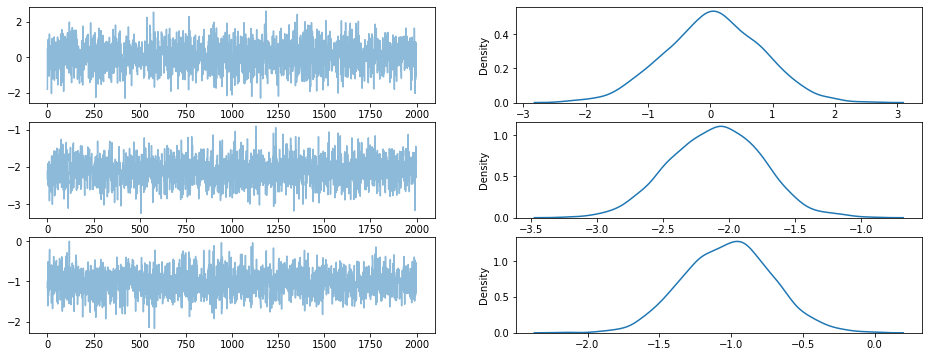

In [238]:
fig, ax = plt.subplots(3, 2, figsize=(16, 6))

plot_data = [
    samples['log_kernel_var'],
    samples['log_kernel_noise'],
    samples['log_kernel_length']
]

for i in range(3):
    ax[i,0].plot(plot_data[i], alpha=0.5)
    sns.kdeplot(plot_data[i], ax=ax[i,1])

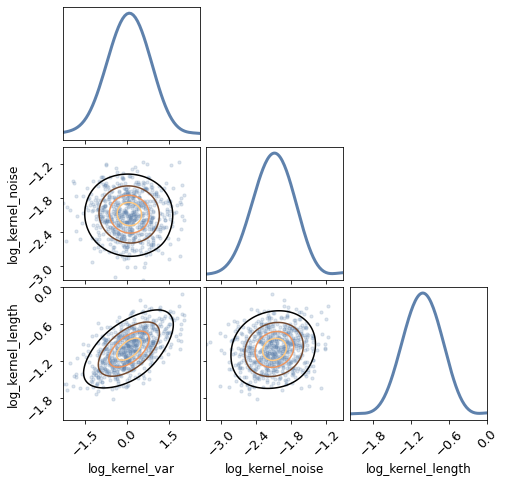

In [233]:
pears.pears(samples, scatter_thin=3, fontsize_labels=12);